In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Adjusting the regular expression to handle scientific notation
number_pattern = r'([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)'

# Function to parse a single line of the file
def parse_line(line):
    numbers = re.findall(number_pattern, line)
    return {
        'epoch': int(numbers[0]),
        'step': int(numbers[1]),
        'train_time': float(numbers[2]),
        'train_acc': float(numbers[3]),
        'test_acc': float(numbers[4]),
        'test_ema_acc': float(numbers[5]),
        'train_nll': float(numbers[6]),
        'test_nll': float(numbers[7]),
        'test_ema_nll': float(numbers[8]),
        'train_loss': float(numbers[9]),
        'train_kl': float(re.search(r'tensor\(\[([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\]', line).group(1)),
        'train_ece': float(numbers[10]),
        'test_ece': float(numbers[11]),
        'test_ece_ema': float(numbers[12]),
        'train_nfes': float(numbers[13]),
        'test_nfe': float(numbers[14]),
        'test_nfe_ema': float(numbers[15])
    }

# Function to parse a file and return a DataFrame
def parse_file(file_path):
    results = []
    with open(file_path, 'r') as file:
        for line in file:
            results.append(parse_line(line))
    return pd.DataFrame(results)

# Function to plot metrics
def plot_metrics(df, title_suffix=''):
    plt.figure(figsize=(14, 10))

    # Subplot for Training and Test Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy')
    plt.plot(df['epoch'], df['test_acc'], label='Test Accuracy')
    plt.plot(df['epoch'], df['test_ema_acc'], label='Test EMA Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Test Accuracy {title_suffix}')
    plt.legend()

    # Subplot for Training and Test NLL
    plt.subplot(2, 2, 2)
    plt.plot(df['epoch'], df['train_nll'], label='Train NLL')
    plt.plot(df['epoch'], df['test_nll'], label='Test NLL')
    plt.plot(df['epoch'], df['test_ema_nll'], label='Test EMA NLL')
    plt.xlabel('Epoch')
    plt.ylabel('Negative Log-Likelihood (NLL)')
    plt.title(f'Training and Test NLL {title_suffix}')
    plt.legend()

    # Subplot for Training and Test ECE
    plt.subplot(2, 2, 3)
    plt.plot(df['epoch'], df['train_ece'], label='Train ECE')
    plt.plot(df['epoch'], df['test_ece'], label='Test ECE')
    plt.plot(df['epoch'], df['test_ece_ema'], label='Test EMA ECE')
    plt.xlabel('Epoch')
    plt.ylabel('Expected Calibration Error (ECE)')
    plt.title(f'Training and Test ECE {title_suffix}')
    plt.legend()

    # Subplot for Test NFE
    plt.subplot(2, 2, 4)
    plt.plot(df['epoch'], df['test_nfe'], label='Test NFE')
    plt.plot(df['epoch'], df['test_nfe_ema'], label='Test EMA NFE')
    plt.xlabel('Epoch')
    plt.ylabel('Number of Function Evaluations (NFE)')
    plt.title(f'Test NFE and Test EMA NFE {title_suffix}')
    plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Function to process multiple files
def process_files(file_paths):
    for file_path in file_paths:
        df = parse_file(file_path)
        plot_metrics(df, title_suffix=f'({file_path})')


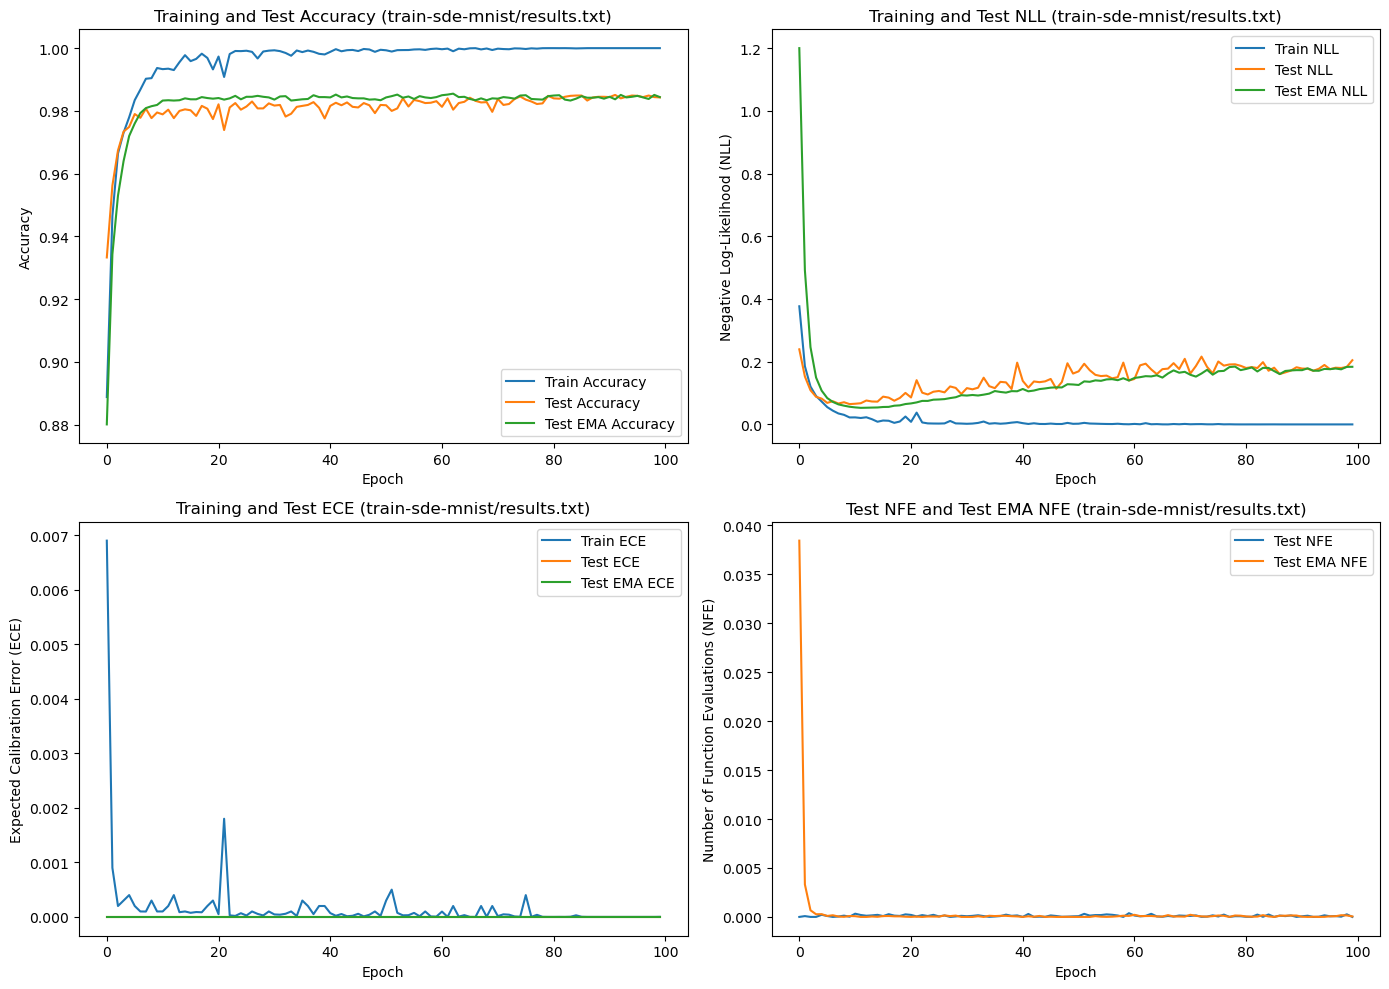

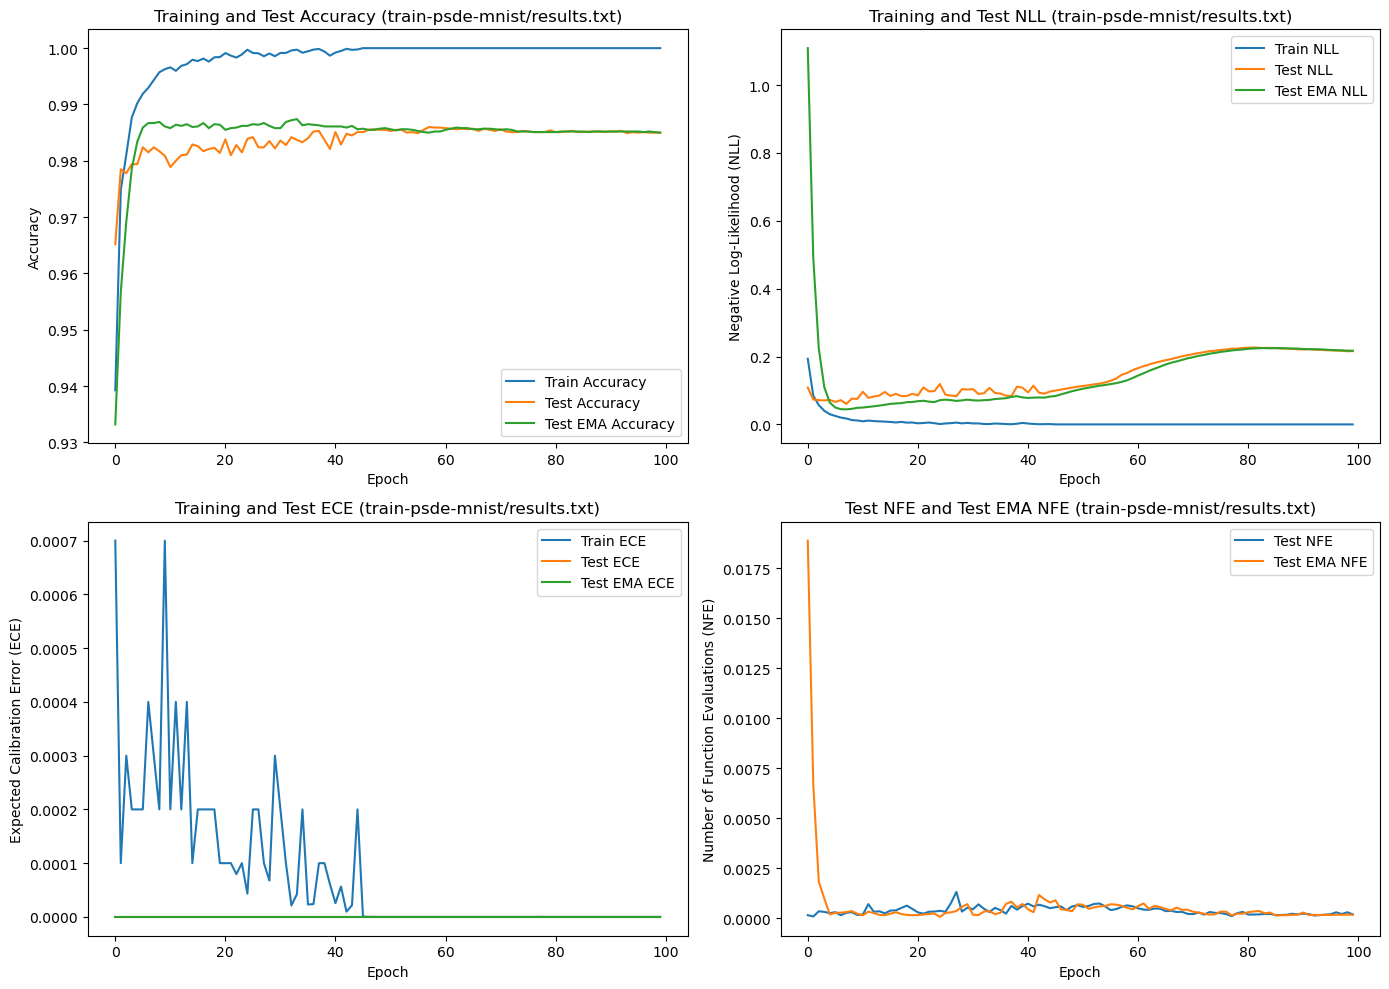

In [4]:
# List of file paths to process
file_paths = [
    'train-sde-mnist/results.txt',
    'train-psde-mnist/results.txt',
    #'train-sde-cifar/results-sde.txt',
]

# Process and plot metrics for all files
process_files(file_paths)

In [4]:
import pandas as pd
import numpy as np

def summarize_results(file_paths):
    summary = {}
    
    for model_name, file_path in file_paths.items():
        df = parse_file(file_path)
        
        # Calculate mean and standard deviation for Time and NFE
        time_mean = df['train_time'].mean()
        time_std = df['train_time'].std()
        nfe_mean = df['test_nfe'].mean()
        nfe_std = df['test_nfe'].std()
        
        # Find the best (max or min as appropriate) EMA results for Accuracy, NLL, and ECE
        best_ema_acc = df['test_ema_acc'].max()
        best_ema_nll = df['test_ema_nll'].min()
        best_ema_ece = df['test_ece_ema'].min()
        
        summary[model_name] = {
            'Accuracy': best_ema_acc,
            'Time': f"{time_mean:.1f}±{time_std:.1f}",
            'EMA Accuracy': f"{best_ema_acc:.1f}±{df['test_ema_acc'].std():.1f}",
            'NLL': f"{best_ema_nll:.3f}±{df['test_ema_nll'].std():.3f}",
            'ECE': f"{best_ema_ece:.3f}±{df['test_ece_ema'].std():.3f}",
            'NFE': f"{nfe_mean:.1f}±{nfe_std:.1f}"
        }
        
    return summary

# Example usage:
file_paths = {
    'SDE-BNN': 'train-sde-mnist/results.txt',
    'PSDE-BNN': 'train-psde-mnist/results.txt',
}

results_summary = summarize_results(file_paths)
for model, results in results_summary.items():
    print(model, results)

SDE-BNN {'Accuracy': 0.9854999780654907, 'Time': '-3036.7±1747.7', 'EMA Accuracy': '1.0±0.0', 'NLL': '0.053±0.121', 'ECE': '0.000±0.000', 'NFE': '0.0±0.0'}
PSDE-BNN {'Accuracy': 0.9873999953269958, 'Time': '-2706.4±1556.7', 'EMA Accuracy': '1.0±0.0', 'NLL': '0.044±0.123', 'ECE': '0.000±0.000', 'NFE': '0.0±0.0'}


In [5]:
import pandas as pd
import numpy as np

def summarize_results(file_paths, last_n_epochs=10):
    summary = {}

    for model_name, file_path in file_paths.items():
        df = parse_file(file_path)
        
        # Calculate mean and standard deviation for Time
        time_mean = df['train_time'].mean()
        time_std = df['train_time'].std()
        
        # Get the last N epochs where the model is assumed to have stabilized
        stable_df = df[-last_n_epochs:]
        
        # Calculate the average and standard deviation for stable ECE and NFE
        ece_mean = stable_df['test_ece_ema'].mean()
        ece_std = stable_df['test_ece_ema'].std()
        nfe_mean = stable_df['test_nfe_ema'].mean()
        nfe_std = stable_df['test_nfe_ema'].std()
        
        # Find the best (max for accuracy, min for NLL) EMA results
        best_ema_acc = df['test_ema_acc'].max()
        best_ema_nll = df['test_ema_nll'].min()
        
        summary[model_name] = {
            'Accuracy': f"{best_ema_acc:.2f}",
            'Time': f"{time_mean:.1f}±{time_std:.1f}",
            'EMA Accuracy': f"{best_ema_acc:.2f}±{df['test_ema_acc'].std():.2f}",
            'NLL': f"{best_ema_nll:.3f}±{df['test_ema_nll'].std():.3f}",
            'ECE': f"{ece_mean:.4f}±{ece_std:.4f}",
            'NFE': f"{nfe_mean:.0f}±{nfe_std:.0f}"
        }

    return summary

file_paths = {
    'SDE-BNN': 'train-sde-mnist/results.txt',
    'PSDE-BNN': 'train-psde-mnist/results.txt',
}

results_summary = summarize_results(file_paths, last_n_epochs=10)
for model, results in results_summary.items():
    print(model, results)

SDE-BNN {'Accuracy': '0.99', 'Time': '-3036.7±1747.7', 'EMA Accuracy': '0.99±0.01', 'NLL': '0.053±0.121', 'ECE': '0.0000±0.0000', 'NFE': '0±0'}
PSDE-BNN {'Accuracy': '0.99', 'Time': '-2706.4±1556.7', 'EMA Accuracy': '0.99±0.01', 'NLL': '0.044±0.123', 'ECE': '0.0000±0.0000', 'NFE': '0±0'}
